# Global DS Process
This notebook contains all the process of creating a POC system that will be able to alert a fund manager in case something is happening in his investable universe.

To do this, the aim will be to gather data from news sources and data from the stock markets to see if we can find a correlation between the mood of the news at a given time and the future behaviours in stocks.

In [75]:
!pip install GoogleNews
!pip install transformers
!pip install pytrends
!pip install yfinance

In [76]:
import pandas as pd
import numpy as np
import time
import datetime
from IPython.display import clear_output

In [77]:
words_targets = ['TESLA', 'FORD', 'GENERAL MOTORS']

reload_trends, reload_gnews, reload_yahoo_f = False, False, False

## First: Gathering data
A few tests have been made on a few tools :
* twitter v2 API: twitter has bots banning new accounts quite quickly if there is a suspicion that this account has been automatically created, this is what happened and unblocking accounts takes time, so no twitter data for this study
* google trends API: a sample of key words has been chosen (and can be improved) to monitor the state of mind of people around the world, keywords are ['tesla', 'general motors', 'GM', 'ford', 'car', 'oil price', 'industry', 'supply', 'self driving', 'autonomous vehicle']
* bing news: bing gave pretty similar results to google news API, I made the hypothesis that it wouldn't bring a lot of value, google news is far easier to use so in a POC phase, I went with GoogleNews API rather than bing
* News organization APIs have been studied quickly but their results all appeared in google news searches, they were therefore not used
* Yahoo finance: The stock values of the investable universe have been gathered through yahoo finance API

The time target has been set to approximately two years because it should provide enough information for a model to find inference, we will study the market between 03/01/2020 and 10/12/2021.

### Google news

In [78]:
from GoogleNews import GoogleNews
from dataclasses import dataclass

#time steps must be created because google news API limits to 100 results per request
#to avoid having only 100 or so articles for two years, let's create weekly time steps
@dataclass
class timeStep:
    start: datetime.datetime
    end: datetime.datetime

if reload_gnews:
    global_start, global_end = '03/01/2020','10/12/2021'

    #one time step per week
    time_steps = []
    current_date = datetime.datetime.strptime(global_start, "%d/%m/%Y")
    end_date = datetime.datetime.strptime(global_end, "%d/%m/%Y")
    while current_date < end_date:
        current_end = current_date + datetime.timedelta(days=7)
        time_steps.append(timeStep(start=current_date.strftime("%d/%m/%Y"), end=current_end.strftime("%d/%m/%Y")))
        current_date = current_end

Now that the time steps are defined, let's call the API to gather : title, datetime and link mainly

In [79]:
if reload_gnews:
    #initialize dictionaries
    res = {}
    for target in words_targets:
        res[target] = []

    #crawling for each time step
    for time_step in time_steps:
        clear_output(wait=True)
        #printing to know where we are in a long process of around 10 minutes
        print(time_step.start)
        googlenews = GoogleNews(start=time_step.start,end=time_step.end)
        for target in words_targets:
            googlenews.get_news(target)
            #adding the gathered articles to the ones already gathered from previous weeks
            results = googlenews.results()
            for result in results:
                result['week_date'] = time_step.start
            res[target].extend(results)
            googlenews.clear()
            #and wait a little bit because google would ban too many calls in a small period of time
            time.sleep(1)
            
    #and saving the results in csv files locally so that we don't need to regenerate the results each time
    for key, value in res.items():
        file_name = "data/gnews_"+key+".csv"
        df = pd.DataFrame(value)
        df.to_csv(file_name, index=True)

### Google Trends
It can be interesting to see how many requests have been made to google on the following terms : ['tesla', 'general motors', 'GM', 'ford', 'car', 'oil price', 'industry', 'supply', 'self driving', 'autonomous vehicle']
This list could grow if first results from the project are positive and if google trends inputs prove valuable for the algorithm that will be made later in this notebook.

In [80]:
from pytrends.request import TrendReq

if reload_trends:
    interest_list = ['tesla', 'general motors', 'GM', 'ford', 'car', 'oil price', 'industry', 'supply', 'self driving', 'autonomous vehicle']

    pytrend = TrendReq()
    pytrend.build_payload(kw_list=interest_list[:5])#API is limited to five keywords at a time so we will do this in two steps

    trends_over_time1 = pytrend.interest_over_time()#method interest over time returns the number of requests per day for the last 5 years
    del trends_over_time1['isPartial']

    pytrend = TrendReq()
    pytrend.build_payload(kw_list=interest_list[5:])
    trends_over_time2 = pytrend.interest_over_time()
    del trends_over_time2['isPartial']

    #as it has been done in two steps, let's concatenate
    trends_over_time = pd.concat([trends_over_time1, trends_over_time2], axis=1)

    #and save
    trends_over_time.to_csv('data/trends.csv', index=True)

### Yahoo finance
The yahoo finance API is very simple to use (one line of code to gather data). Not much to say here, we just retrieve stock values for Tesla, Ford and General motors over the past two years.

In [81]:
import yfinance as yf

if reload_yahoo_f:
    data = yf.download("TSLA GM F", start="2020-01-03", end="2021-12-10")

    #the data contains multiple level indexes that will make the data difficult to save and read so let's collapse column names into single index
    data.columns = [' '.join(col).strip() for col in data.columns.values]

    data.to_csv('data/yahoo_values.csv', index=True)

## Analyzing the data
Now that the technical gathering of data has been done, let's see what really is in the gathered data (this process has been iterative of course going back and fourth to have exploitable data, this wasn't the case right away).

In [82]:
#first let's see how the stocks we are going to study did fare
yahoo_data = pd.read_csv('data/yahoo_values.csv')

yahoo_data

,Date,Adj Close F,Adj Close GM,Adj Close TSLA,Close F,Close GM,Close TSLA,High F,High GM,High TSLA,Low F,Low GM,Low TSLA,Open F,Open GM,Open TSLA,Volume F,Volume GM,Volume TSLA
0,2020-01-02,9.216070,36.929497,430.260010,9.420000,37.380001,430.260010,9.420000,37.380001,430.695709,9.190000,36.549999,421.709991,9.290000,37.000000,424.500000,43432239,7457292,9558386
1,2020-01-03,9.010616,35.882271,443.010010,9.210000,36.320000,443.010010,9.370000,36.919998,454.000000,9.150000,36.110001,436.920013,9.310000,36.730000,440.500000,45059915,9176038,17794697
2,2020-01-06,8.961699,35.408058,451.540009,9.160000,35.840000,451.540009,9.170000,36.180000,451.559998,9.060000,35.799999,440.000000,9.100000,35.950001,440.470001,43380677,8413360,10157499
3,2020-01-07,9.049750,34.726376,469.059998,9.250000,35.150002,469.059998,9.250000,35.840000,471.630005,9.120000,34.740002,453.355011,9.200000,35.750000,461.399994,43909990,17087304,17735603
4,2020-01-08,9.049750,34.232399,492.140015,9.250000,34.650002,492.140015,9.300000,35.200001,498.489990,9.170000,34.410000,468.230011,9.230000,35.040001,473.700012,46003049,13229924,31199393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2021-12-03,19.139999,59.709999,1014.969971,19.139999,59.709999,1014.969971,20.400000,61.689999,1090.575317,18.930000,58.869999,1000.210022,20.370001,61.235001,1084.790039,120275163,19596053,30773995
486,2021-12-06,19.219999,59.840000,1009.010010,19.219999,59.840000,1009.010010,19.490000,60.730000,1021.640015,18.614799,58.700001,950.500000,19.230000,60.470001,1001.510010,88147408,16728215,27221037
487,2021-12-07,19.959999,61.529999,1051.750000,19.959999,61.529999,1051.750000,20.059999,62.380001,1057.673950,19.520000,60.700001,1026.810059,19.650000,60.910000,1044.199951,75885619,14135732,18694857
488,2021-12-08,19.809999,60.779999,1068.959961,19.809999,60.779999,1068.959961,20.190001,61.810001,1072.380005,19.750000,60.418800,1033.000122,20.180000,61.650002,1052.709961,63246825,10004096,13968790


In [83]:
yahoo_data.columns

Index(['Date', 'Adj Close F', 'Adj Close GM', 'Adj Close TSLA', 'Close F',
       'Close GM', 'Close TSLA', 'High F', 'High GM', 'High TSLA', 'Low F',
       'Low GM', 'Low TSLA', 'Open F', 'Open GM', 'Open TSLA', 'Volume F',
       'Volume GM', 'Volume TSLA'],
      dtype='object')

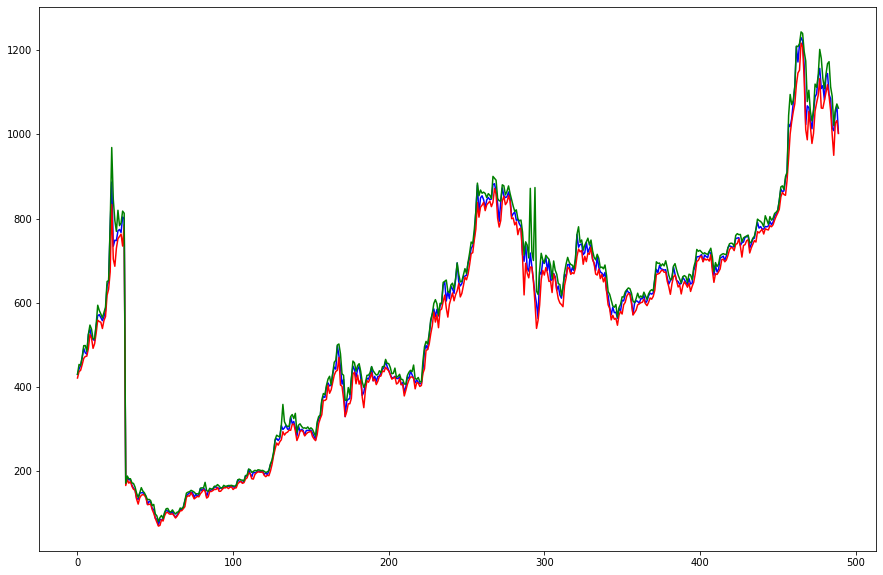

In [84]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(yahoo_data['Close TSLA'].tolist(), 'blue')
plt.plot(yahoo_data['Low TSLA'].tolist(), 'red')
plt.plot(yahoo_data['High TSLA'].tolist(), 'green')
plt.show()

For Tesla, there are a few dates we would like to find special informations for : first drop, high volatility and final step up

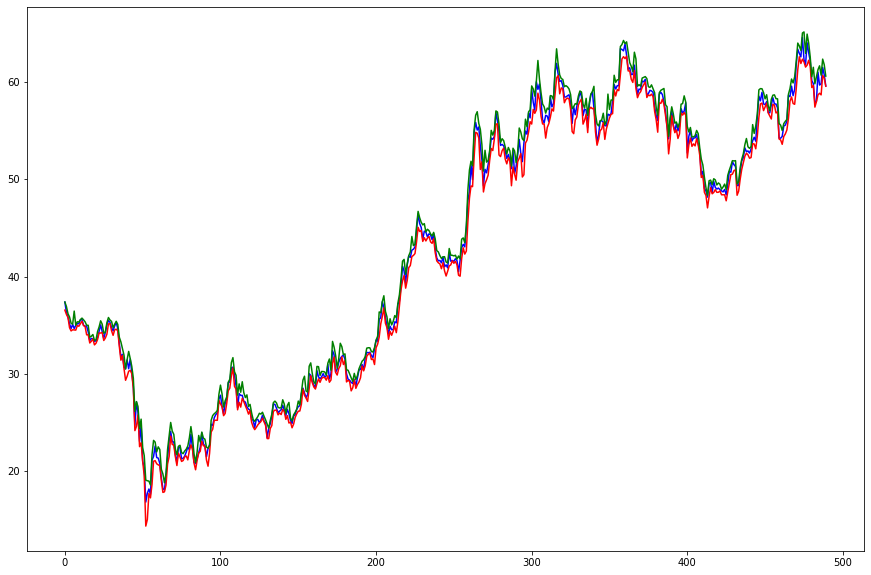

In [85]:
plt.figure(figsize=(15,10))
plt.plot(yahoo_data['Close GM'].tolist(), 'blue')
plt.plot(yahoo_data['Low GM'].tolist(), 'red')
plt.plot(yahoo_data['High GM'].tolist(), 'green')
plt.show()

Much more steady stock without dear Elon's tweets. We can investigate slope increases. Let's also see what we can do about volatility to predict future events.

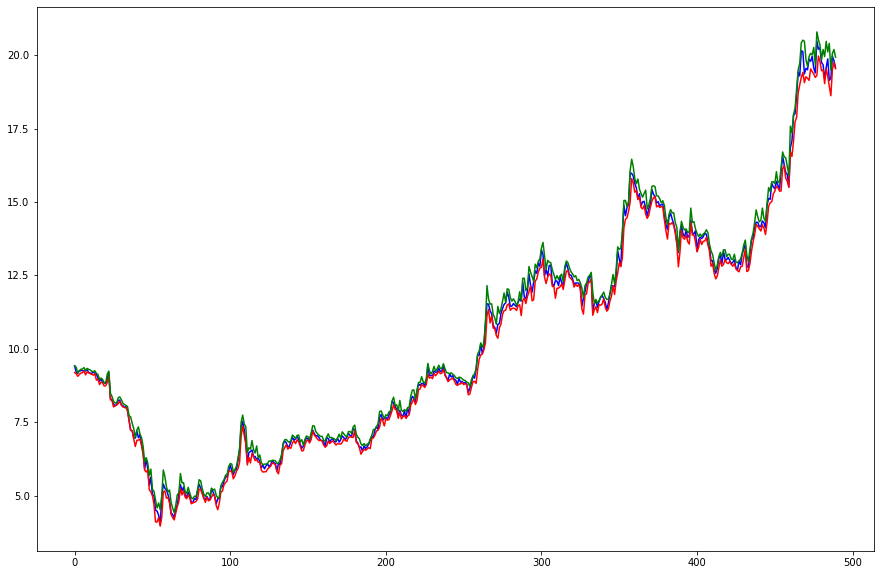

In [86]:
plt.figure(figsize=(15,10))
plt.plot(yahoo_data['Close F'].tolist(), 'blue')
plt.plot(yahoo_data['Low F'].tolist(), 'red')
plt.plot(yahoo_data['High F'].tolist(), 'green')
plt.show()

## Defining what to look for
Something that should be run by the business before but let's suppose we look for two things : steady trend appearing, volatility increase or decrease.

We need to define those terms mathematically so that they can be calculated for every time step recorded with yahoo finance data:
* Variables:
    * closing value: $C$
    * highest value: $H$
    * lowest value: $L$
    * opening value: $O$
* Parameters:
    * steady trend time parameter: $T_s$
    * volatitily time parameter: $T_v$
    
for these calculations, to have delete variations linked to stock price, we will divide by the first stock price so that we delete scale disparities.

### Steady trends
A steady trend is a long term trend that can encounter small noise but stays consistent for a time greater than the steady trend param: st. A constant value followed by a quick adjustement up or down shouldn't be seen as a steady trend so we cannot just take begin value and end value over a period of time. A steady trend is a series of higher and higher values (or lower and lower) over a great period of time with an end value greater than the original value. This formula is certainly non optimal but it should reflect an interesting feature :
$$T(t)=\frac{C(t+st)-C(t+1)}{T_s}\sum \limits _{i=t+1} ^{t+T_s} (C(i)-C(t))$$

### Volatility
One representation of volatility could simply be defined as the moving average of the difference between ups and downs in one day during a vt period.
$$V(t) = \frac{1}{T_v}\sum \limits _{i=t+1} ^{t+T_v} (H(i)-L(i))$$


In [87]:
#defining parameters
Ts = 50
Tv = 5

#Let's put those indicators in numpy arrays:
stock_targets = ['F', 'GM', 'TSLA']

high, low, close = {}, {}, {}
for target in stock_targets:
    high[target] = yahoo_data['High '+target].tolist()
    low[target] = yahoo_data['Low '+target].tolist()
    close[target] = yahoo_data['Close '+target].tolist()
    
def calc_steady_trend(closing_serie):
    result = []
    for i in range(len(closing_serie)-Ts):
        result.append((closing_serie[i+Ts]-closing_serie[i+1])*sum(closing_serie[i:i+Ts])/Ts/closing_serie[0])
        #could have done it with list comprehension but maybe more readable this way
    return result

def calc_volatility(high_serie, low_serie):
    return [sum(high_serie[i:i+Tv])-sum(low_serie[i:i+Tv])/high_serie[0] for i in range(len(high_serie)-Tv)]


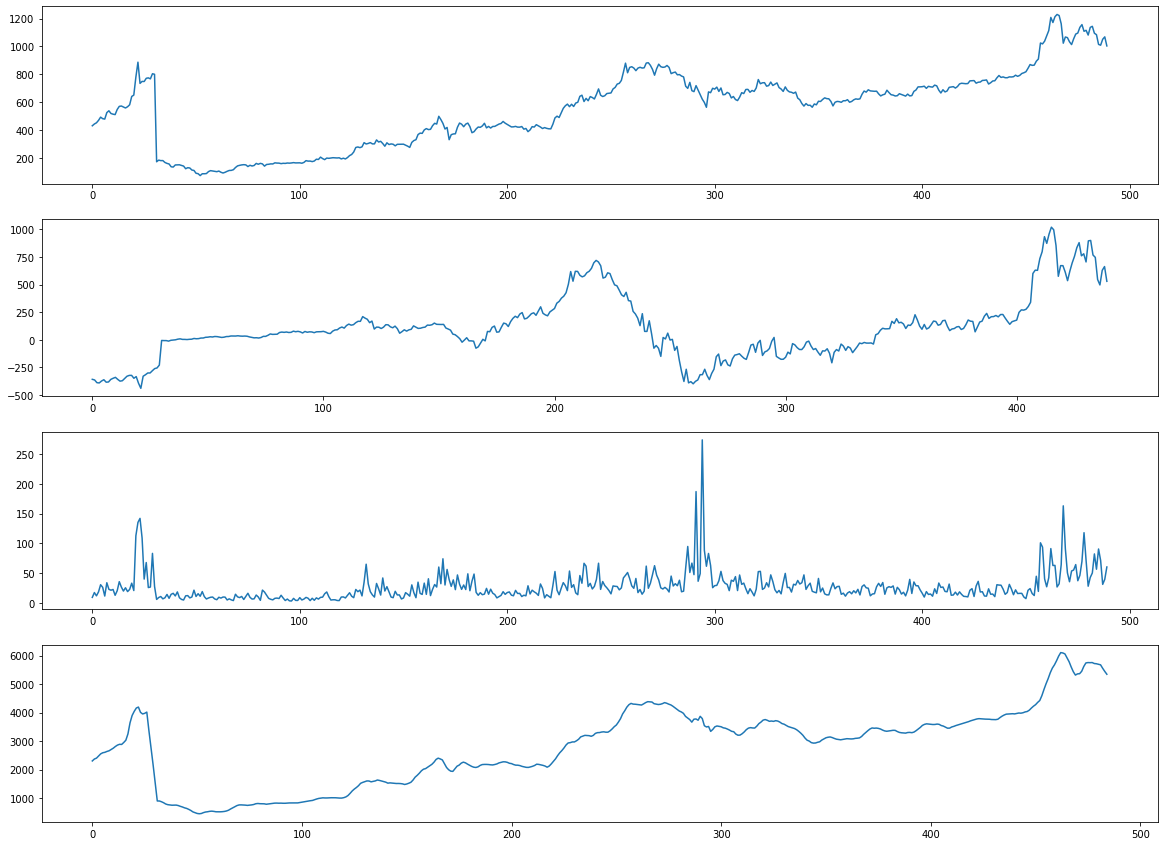

In [88]:
target = 'TSLA'

high_low_diff = [high[target][i]-low[target][i] for i in range(len(high['F']))]#to check whether difference between high and low is coherent with volatility
steady_trend = calc_steady_trend(close[target])
volatility = calc_volatility(high[target], low[target])

f, axs = plt.subplots(4,figsize=(20,15))
axs[0].plot(close[target])
axs[1].plot(steady_trend)
axs[2].plot(high_low_diff)
axs[3].plot(volatility)

It checks out, as said before those indicators could be enhanced greatly, we could also use known and well established indicators but let's use those just to show that creating indicators based on specific needs isn't a problem.

And now put in a dataframe the values that BERT is going to have to do regression tasks on:

In [89]:
steady_trend = {}
volatility = {}

len_labels = len(high['F'])-Ts
dates = list(yahoo_data['Date'])

#calculate labels for the algorithm
for target in stock_targets:
    steady_trend[target] = list(map(abs,calc_steady_trend(close[target])))
    #and normalisation:
    median = np.percentile(np.array(steady_trend[target]), 50)#TODO add consideration for low trends : absolute value
    steady_trend[target] = [1 if s > median else 0 for s in steady_trend[target]]
    volatility[target] = list(map(abs,calc_volatility(high[target], low[target])))
    median = np.percentile(np.array(volatility[target]), 50)
    volatility[target] = [1 if v > median else 0 for v in volatility[target]]

#put labels in list of dict
global_labels = []
for target in stock_targets:
    for i in range(len_labels):
        global_labels.append({'target':target, 'date':dates[i], 'label_t': steady_trend[target][i], 'label_v': volatility[target][i]})

labels = pd.DataFrame(global_labels)

In [90]:
labels

,target,date,label_t,label_v
0,F,2020-01-02,1,1
1,F,2020-01-03,1,0
2,F,2020-01-06,1,0
3,F,2020-01-07,1,1
4,F,2020-01-08,1,1
...,...,...,...,...
1315,TSLA,2021-09-23,1,1
1316,TSLA,2021-09-24,1,1
1317,TSLA,2021-09-27,1,1
1318,TSLA,2021-09-28,1,1


## NLP processing
Let's now work with the data gathered from google news. According to benchmarks, BERT seems the most capable of understanding a text in detail and correlating this with our stock features. Let's try this.

In [91]:
#then what is our data made of :
gnews_f = pd.read_csv('data/gnews_FORD.csv')
gnews_f['target'] = 'F'
gnews_gm = pd.read_csv('data/gnews_GENERAL MOTORS.csv')
gnews_gm['target'] = 'GM'
gnews_tsla = pd.read_csv('data/gnews_TESLA.csv')
gnews_tsla['target'] = 'TSLA'
gnews = pd.concat([gnews_f, gnews_gm, gnews_tsla])

del gnews['Unnamed: 0']#sorry for this glitch, shouldn't appear
del gnews['desc']
del gnews['date']
del gnews['datetime']
del gnews['img']
del gnews['media']
del gnews['site']
del gnews['link']

gnews.reset_index(drop=True, inplace=True)

gnews

,title,week_date,target
0,Ford: when I blamed young people for spreading...,03/01/2020,F
1,🔒 A look back: Christmas Fantasy at the iconic...,03/01/2020,F
2,This Supercar Pays Tribute to Ford’s Le Mans H...,03/01/2020,F
3,Ford CEO Farley Says Company's Ready to Compet...,03/01/2020,F
4,"Andover Stories: Ford's coffee shop memories, ...",03/01/2020,F
...,...,...,...
23727,"Tesla’s $25,000 electric car rendered as sport...",03/12/2021,TSLA
23728,"Tesla Sells ‘Full Self-Driving,’ but What Is I...",03/12/2021,TSLA
23729,"If You Invested $1,000 in Tesla in 2010, This ...",03/12/2021,TSLA
23730,Tesla increases Model 3 and Model Y ranges wit...,03/12/2021,TSLA


To merge the dataframe containing the texts and the dataframe containing the labels, we need to change the date format. It will be easier to sort with the format from labels so let's tranform this dataframe's date format.

In [92]:
def switch_date_format(slash_date):
    return slash_date[6:]+'-'+slash_date[3:5]+'-'+slash_date[:2]

gnews['week_date'] = gnews['week_date'].apply(switch_date_format)

gnews

,title,week_date,target
0,Ford: when I blamed young people for spreading...,2020-01-03,F
1,🔒 A look back: Christmas Fantasy at the iconic...,2020-01-03,F
2,This Supercar Pays Tribute to Ford’s Le Mans H...,2020-01-03,F
3,Ford CEO Farley Says Company's Ready to Compet...,2020-01-03,F
4,"Andover Stories: Ford's coffee shop memories, ...",2020-01-03,F
...,...,...,...
23727,"Tesla’s $25,000 electric car rendered as sport...",2021-12-03,TSLA
23728,"Tesla Sells ‘Full Self-Driving,’ but What Is I...",2021-12-03,TSLA
23729,"If You Invested $1,000 in Tesla in 2010, This ...",2021-12-03,TSLA
23730,Tesla increases Model 3 and Model Y ranges wit...,2021-12-03,TSLA


In [93]:
data = pd.merge(gnews, labels, how="left", left_on=['week_date','target'], right_on=['date', 'target'])

data

,title,week_date,target,date,label_t,label_v
0,Ford: when I blamed young people for spreading...,2020-01-03,F,2020-01-03,1.0,0.0
1,🔒 A look back: Christmas Fantasy at the iconic...,2020-01-03,F,2020-01-03,1.0,0.0
2,This Supercar Pays Tribute to Ford’s Le Mans H...,2020-01-03,F,2020-01-03,1.0,0.0
3,Ford CEO Farley Says Company's Ready to Compet...,2020-01-03,F,2020-01-03,1.0,0.0
4,"Andover Stories: Ford's coffee shop memories, ...",2020-01-03,F,2020-01-03,1.0,0.0
...,...,...,...,...,...,...
23727,"Tesla’s $25,000 electric car rendered as sport...",2021-12-03,TSLA,NaN,NaN,NaN
23728,"Tesla Sells ‘Full Self-Driving,’ but What Is I...",2021-12-03,TSLA,NaN,NaN,NaN
23729,"If You Invested $1,000 in Tesla in 2010, This ...",2021-12-03,TSLA,NaN,NaN,NaN
23730,Tesla increases Model 3 and Model Y ranges wit...,2021-12-03,TSLA,NaN,NaN,NaN


And we have all the last columns to NaN because there wasn't any trend we could calculate for the last Ts dates. We can drop the last dates for which there is no entry.

In [94]:
data = data.dropna()

data

,title,week_date,target,date,label_t,label_v
0,Ford: when I blamed young people for spreading...,2020-01-03,F,2020-01-03,1.0,0.0
1,🔒 A look back: Christmas Fantasy at the iconic...,2020-01-03,F,2020-01-03,1.0,0.0
2,This Supercar Pays Tribute to Ford’s Le Mans H...,2020-01-03,F,2020-01-03,1.0,0.0
3,Ford CEO Farley Says Company's Ready to Compet...,2020-01-03,F,2020-01-03,1.0,0.0
4,"Andover Stories: Ford's coffee shop memories, ...",2020-01-03,F,2020-01-03,1.0,0.0
...,...,...,...,...,...,...
22828,"If You Invested $1,000 in Tesla in 2010, This ...",2021-09-24,TSLA,2021-09-24,1.0,1.0
22829,Tesla AI Day event: start time and how to watc...,2021-09-24,TSLA,2021-09-24,1.0,1.0
22830,Tesla (TSLA) is going on a salesforce hiring s...,2021-09-24,TSLA,2021-09-24,1.0,1.0
22831,"Are Teslas Compatible with Apple iPhone, Apple...",2021-09-24,TSLA,2021-09-24,1.0,1.0


## Creating a BERT model for regression

In [95]:
from transformers import TFBertModel
import tensorflow as tf

model = TFBertModel.from_pretrained('bert-base-uncased')

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [96]:
print(max(data['date'].tolist()), min(data['date'].tolist()))#to know what date to choose for splitting train and test for cross validation

2021-09-24 2020-01-03


In [97]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

seq_len = 64
num_samples = len(data)

split_date = '2021-05-01'

data_train = data[data['date'] < split_date]
data_test = data[data['date'] >= split_date]

def mapping(X, mask, y):
    return {'input_ids': X, 'attention_mask':mask}, y

def create_dataset(df):
    Xids = np.zeros((num_samples, seq_len))
    Xmask = np.zeros((num_samples, seq_len))

    for i, phrase in enumerate(data_train['title']):
        tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')

        Xids[i,:] = tokens['input_ids']
        Xmask[i,:] = tokens['attention_mask']
    labels = np.asarray(data[['label_t', 'label_v']])
    dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))


    dataset = dataset.map(mapping)
    batch_size = 16

    dataset = dataset.shuffle(123456).batch(batch_size, drop_remainder=True)
    return dataset

train_ds = create_dataset(data_train)
val_ds = create_dataset(data_test)

In [98]:
model.summary()

Model: "tf_bert_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [99]:
# two input layers, layers names must match dictionary keys in the dataset
input_ids = tf.keras.layers.Input(shape=(64,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(64,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object
embeddings = model.bert(input_ids, attention_mask=mask)[1]

# convert bert embeddings into 2 output classes with two dense layers
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(x)

In [100]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# sometimes we can freeze weights in pretrained layers : tested it, crappy results
#model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.MeanSquaredError()


filepath = "model_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callback list

perf_logs = "logs/perf_logs.csv"

f = open(perf_logs, "w+")
f.close()

csv_logger = CSVLogger(perf_logs, append=True, separator=',')

callbacks_list = [checkpoint, csv_logger]

model.compile(optimizer=optimizer, loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [101]:
history = model.fit(train_ds, epochs=3, validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/3
1244/1244 [==============================] - ETA: 0s - loss: 0.2400 - acc: 0.0000e+00
Epoch 00001: val_acc improved from inf to 0.00000, saving model to model_best.hdf5
1244/1244 [==============================] - 717s 567ms/step - loss: 0.2400 - acc: 0.0000e+00 - val_loss: 0.2354 - val_acc: 0.0000e+00
Epoch 2/3
1244/1244 [==============================] - ETA: 0s - loss: 0.2360 - acc: 0.0000e+00
Epoch 00002: val_acc did not improve from 0.00000
1244/1244 [==============================] - 691s 555ms/step - loss: 0.2360 - acc: 0.0000e+00 - val_loss: 0.2369 - val_acc: 0.0000e+00
Epoch 3/3
1244/1244 [==============================] - ETA: 0s - loss: 0.2350 - acc: 0.0000e+00
Epoch 00003: val_acc did not improve from 0.00000
1244/1244 [==============================] - 692s 556ms/step - loss: 0.2350 - acc: 0.0000e+00 - val_loss: 0.2337 - val_acc: 0.0000e+00


Not great results but the model is able to evolve a little bit from MSE=0.25 and certainly underfits as BERT models generally take at least 10 epochs to start efficient learning on datasets of this size.

In [ ]:
model.load_weights(filepath)

## Analyse the results
The results won't be great but could in my opinion greatly be improved after some tweaks and with addition of more naive sentiment analysis algorithms during preprocessing.

Let's see how many alerts should have been put in place and how many we missed as well as how many false alerts were raised.

In [105]:
def one_inference(text, model):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = tokenizer.encode_plus(text, max_length=64, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')
    to_send = {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
               'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}
    vec = model.predict(to_send)[0]
    if max(vec) > 0.5:
      return 1
    return 0

predictions_table = [one_inference(title, model) for title in data_test['title']]
data_test['y_true'] = data_test.apply(lambda row:max(row['label_t'], row['label_v']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [107]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data_test['y_true'].tolist(), predictions_table)

print(cm)

[[0 0]
 [1 9]]
